In [9]:
import matplotlib.pyplot as plt

In [1]:
import DALI as dali_code
from pytube import YouTube
import subprocess

import os
import numpy as np

# import tqdm
from tqdm import tqdm

# Load the dataset

In [3]:
absolute_path = os.path.dirname(os.path.abspath("main.ipynb"))
dali_data_path = os.path.join(absolute_path, r"..\Dataset\data\dali_samples")

In [4]:
dali_data = dali_code.get_the_DALI_dataset(dali_data_path, skip=[], keep=[])

In [5]:
dali_info = dali_code.get_info(os.path.join(dali_data_path, r'info\DALI_DATA_INFO.gz'))
print(dali_info[0])

song_metadata = dali_info[1:]
song_metadata[230]

['DALI_ID' 'NAME' 'YOUTUBE' 'WORKING']


array(['f49052ac9096484eb17a9efd66f27d63', 'Kanye_West-Lost_In_The_World',
       'ofaRvNOV4SI', 'True'], dtype='<U77')

In [30]:
dali_data[song_metadata[0][0]].annotations['type']

'horizontal'

In [31]:
def segment_dali(duration_threshold: int = 10):
    import json

    segments = []
    # loop through songs
    for i in range(0, len(song_metadata)):
        lines = dali_data[song_metadata[i][0]].annotations['annot']['lines']
        segment_dict = {
            'id': song_metadata[i][0],
            'artist': song_metadata[i][1].split("-")[0],
            'title': song_metadata[i][1].split("-")[1],
            'youtube': song_metadata[i][2],
            'line': ""
        }
        start_time = lines[0]['time'][0]
        end_time = lines[0]['time'][1]
        # loop through lines of the song
        for line in lines:
            #print("line timestamps:", line['time'][1] - line['time'][0])
            time = line['time'][1]
            if time - start_time > duration_threshold:
                if end_time - start_time == 0:
                    continue
                segment_dict['start_time'] = start_time
                segment_dict['end_time'] = end_time
                segments.append(segment_dict.copy())
                start_time = end_time = time
                segment_dict['line'] = ""
            else:
                end_time = time
                segment_dict['line'] += line['text']
                if len(line['text']) > 0:
                    segment_dict['line'] += ". " if segment_dict['line'][-1] == "," else " "

    with open('data/segments.json', 'w') as f:
        json.dump(segments, f)



In [5]:
import json
with open('data/segments.json', 'r') as f:
    segments = json.load(f)

In [8]:
segments[0].keys()

dict_keys(['id', 'artist', 'title', 'youtube', 'line', 'start_time', 'end_time'])

In [36]:
import torch
import sys
sys.path.append('..')

from Dataset.DALIDataset import DALIDataset
from torch.utils.data import DataLoader

In [37]:
dataset = DALIDataset()
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [38]:
for i, data in enumerate(dataloader, 0):
    print(i, data)

KeyboardInterrupt: 

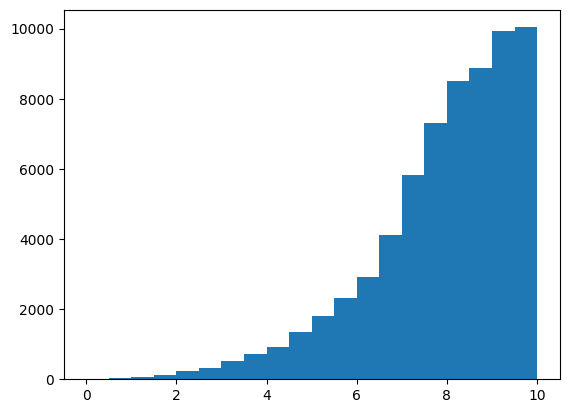

In [86]:
# plot the distribution of segment lengths
counts = plt.hist([segment['end_time'] - segment['start_time'] for segment in segments], bins=20, range=(0, duration_threshold), cumulative=False)[0:2]

In [87]:
print(len(counts[0]), len(counts[1][1:])
)
print(f"{counts[0]}\n{counts[1]}")

20 20
[   13.    27.    69.   133.   224.   324.   513.   731.   912.  1334.
  1818.  2321.  2922.  4123.  5836.  7310.  8511.  8868.  9933. 10037.]
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]


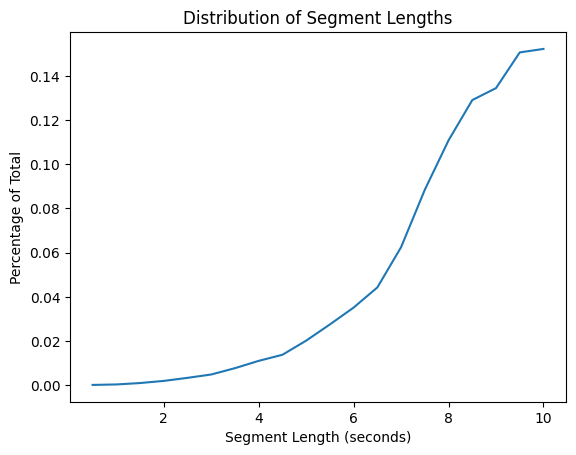

In [88]:
# plot counts as percentages of total
plt.plot(counts[1][1:], counts[0] / sum(counts[0]))
plt.xlabel('Segment Length (seconds)')
plt.ylabel('Percentage of Total')
plt.title('Distribution of Segment Lengths')
plt.show()

In [7]:
[print(i) for i in range(len(song_metadata)) if ("Kanye" in song_metadata[i][1])]

230
2616


[None, None]

In [66]:
# broken_links += get_audio(song_metadata, progress=1964)

1964. Tom_Frager-Lady_Melody already converted to wav format
1965. Creed-One already converted to wav format
1966. Basshunter-Boten_Anna download failed: zf2wbRWb9xI is age restricted, and can't be accessed without logging in.
1967. Demi_Lovato-La_La_Land already converted to wav format
1968. Jeane_Manson-Avant_De_Nous_Dire_Adieu already converted to wav format
1969. Cali-C'est_Quand_Le_Bonheur already converted to wav format
1970. Gino_Vannelli-Wild_Horses already converted to wav format
1971. Radiohead-Karma_Police successfully converted to wav format
1972. The_Rasmus-First_Day_Of_My_Life successfully converted to wav format
1973. Deer_Tick-Ashamed download failed: kRQNQF4-ofs is unavailable
1974. Becky_G-Shower successfully converted to wav format
1975. Brandy-What_About_Us? download failed: rzSvqOEKl-M is unavailable
1976. Feeder-Buck_Rogers conversion failed
1977. Lionel_Richie-Hello download failed: [Errno 28] No space left on device
1978. Green_Day-Sassafras_Roots download faile

In [6]:

def run_ffmpeg(input_file, output_file):
    with open(os.devnull, 'w') as FNULL:
        return subprocess.call(['ffmpeg', '-i', input_file, output_file], stdout=FNULL, stderr=subprocess.STDOUT)


def get_audio(song_metadata, progress=0):
    """Download audio from youtube links and convert to wav format.
    
    Args:
        song_metadata (list): list of tuples containing the song metadata
        progress (int): index to start from
    
    Returns:
        list: list of dali_ids for the broken links"""

    broken_links = []
    for i in range(progress, len(song_metadata)):
        dali_id, song_name, youtube_uri, working = song_metadata[i]

        if working != "True":
            print(f"{i}. {song_name} link is broken")
            broken_links.append(dali_id)
            continue

        if f"{dali_id}.wav" in os.listdir(os.path.join(absolute_path, "data/wav")):
            print(f"{i}. {song_name} already converted to wav format")
            continue
        
        try:
            yt = YouTube(f"https://www.youtube.com/watch?v={youtube_uri}")
            output_path = os.path.join(absolute_path, "data/mp4")

            yt.streams.filter(only_audio=True).first().download(output_path=output_path, filename=f"{dali_id}.mp4")

            input_file = os.path.join(output_path, f"{dali_id}.mp4")
            output_file = os.path.join(absolute_path, r"data\wav", f"{dali_id}.wav")

            result = run_ffmpeg(input_file, output_file)
            if result == 0:
                print(f"{i}. {song_name} successfully converted to wav format")
            else:
                broken_links.append(dali_id)
                print(f"{i}. {song_name} conversion failed")

        except KeyboardInterrupt:
            print(f"Download stopped at {i}")
            break
        except Exception as e:
            broken_links.append(dali_id)
            print(f"{i}. {song_name} download failed: {e}")

    return broken_links



In [7]:
data_path = os.path.join(os.path.dirname(os.path.abspath("main.ipynb")), r"..\Dataset\data")
broken_links_file = os.path.join(data_path, 'broken_links.txt')



In [43]:
import time

def get_broken_links(song_metadata, file_name='broken_links.txt'):
    """Download audio from youtube links.
    
    Args:
        song_metadata (list): list of tuples containing the song metadata
        file_name (str): name of the file to write the broken links to
    
    Returns:
        list: list of dali_ids for the broken links"""
    
    def write_broken_links(broken_links, file_name):
        with open(file_name, 'w') as f:
            f.write("\n".join(broken_links))
    
    broken_links = []
    last_broken_link_index = 0

    data_path = os.path.join(os.path.dirname(os.path.abspath("main.ipynb")), r"..\Dataset\data")
    broken_links_file = os.path.join(data_path, file_name)
    mp4_dir = os.path.join(data_path, "mp4")
    
    # if text file of broken links DNE or is empty, create it
    if not os.path.exists(broken_links_file) or os.path.getsize(broken_links_file) == 0:
        write_broken_links(broken_links, broken_links_file)

    else:
        with open(broken_links_file, 'r') as f:
            broken_links = f.read().split("\n")
        # get the last broken link
        last_broken_link = broken_links[-1]
        # get the index of the last broken link
        last_broken_link_index = [song_metadata[i][0] for i in range(len(song_metadata))].index(last_broken_link)

    print(f"Resuming from index {last_broken_link_index}")

    broken_links = []
    for i in range(last_broken_link_index, len(song_metadata)):
        # write to file every 100 iterations
        if i % 10 == 0:
            write_broken_links(broken_links, broken_links_file)

        dali_id, song_name, youtube_uri, _ = song_metadata[i]
        mp4_file = f"{dali_id}.mp4"
        
        try:
            start = time.time()
            # download the youtube video with a timeout of 5 seconds
            yt = YouTube(f"https://www.youtube.com/watch?v={youtube_uri}")
            yt.streams.filter(only_audio=True).first().download(output_path=mp4_dir, filename=mp4_file, timeout=5)
            end = time.time()
            assert mp4_file in os.listdir(mp4_dir)
            print(f"{i}. {song_name} link active: downloaded in {end - start} seconds")
            
        except KeyboardInterrupt:
            print(f"Stopped at {i}")
            write_broken_links(broken_links, broken_links_file)
            return broken_links
        except Exception as e:
            # the download failed, so link is broken
            broken_links.append(dali_id)
            print(f"{i}. {song_name} link broken: {e}")

    return broken_links

In [44]:
broken_link_ids = get_broken_links(song_metadata)

Resuming from index 0
0. Staind-Tangled_Up_In_You link active: downloaded in 30.463332653045654 seconds
1. Boyzone-Baby_Can_I_Hold_You link active: downloaded in 29.249979257583618 seconds
2. The_Killers-For_Reasons_Unknown link active: downloaded in 29.24119472503662 seconds
3. Olivia_Newton_John-A_Little_More_Love link active: downloaded in 2.191316604614258 seconds
4. Magtens_Korridorer-Nordhavn_Station link broken: aJCOAZMn9pU is unavailable
5. Alain_Souchon-La_Ballade_De_Jim link broken: lEUy2cGJwG0 is unavailable
6. Entwine-Losing_The_Ground link active: downloaded in 29.912654876708984 seconds
7. Muse-In_Your_World link active: downloaded in 28.606586933135986 seconds
8. Three_Days_Grace-Get_Out_Alive link broken: g8M8OHWX8ng is unavailable
9. Die_Ärzte-Trick_17_M.S. link active: downloaded in 2.4644720554351807 seconds
10. Lea_Michele-Thousand_Needles link broken: ZTNKZnRSlxE is age restricted, and can't be accessed without logging in.
11. Alex_Baroni-Onde link active: download

'NXG-ayocugI'

In [34]:

yt = YouTube(f"https://www.youtube.com/watch?v={song_metadata[0][2]}")
yt.streams.filter(audio_only=True).first().download(filename=song_metadata[0][0], timeout=5)

KeyboardInterrupt: 

In [7]:
import torchaudio
from torchaudio.transforms import Spectrogram



In [1]:
import soundfile


ModuleNotFoundError: No module named '_cffi_backend'

In [8]:
import soundfile
torchaudio.list_audio_backends()

ModuleNotFoundError: No module named '_cffi_backend'

In [11]:
import torch
import torchaudio
from torchaudio.transforms import Spectrogram

def load_audio_segment(filepath, start_sec, end_sec):
    # Load the full audio file
    waveform, sample_rate = torchaudio.load(filepath)
    
    # Calculate start and end sample indices
    start_sample = int(start_sec * sample_rate)
    end_sample = int(end_sec * sample_rate)
    
    # Slice the waveform to get the desired segment
    segment = waveform[:, start_sample:end_sample]
    
    return segment, sample_rate

def generate_spectrogram(waveform, sample_rate):
    # Initialize the Spectrogram transformer
    spectrogram_transformer = Spectrogram()
    
    # Generate spectrogram
    spectrogram = spectrogram_transformer(waveform)
    
    return spectrogram

# Example usage
absolute_path = os.path.dirname(os.path.abspath("main.ipynb"))
file = 'data/wav/0a50b95f828e4217849aa09d4764bcce.wav'
filepath = os.path.join(absolute_path, file)
start_sec = 5.0  # Start time in seconds
end_sec = 10.0  # End time in seconds

segment, sample_rate = load_audio_segment(filepath, start_sec, end_sec)
spectrogram = generate_spectrogram(segment, sample_rate)

# `segment` is the waveform tensor for the specified time segment
# `spectrogram` is the spectrogram tensor for that segment


RuntimeError: Couldn't find appropriate backend to handle uri c:\Users\aimon\Documents\Projects\Audio-to-Language-Alignment-via-Musical-Sentiment\Dataset\data/wav/0a50b95f828e4217849aa09d4764bcce.wav and format None.

[]

# Retrieving some annotations

In [7]:
count = 0
for _, entry in dali_data.items():
    count += 1
    print(entry)
    print(type(entry))
    print(entry.annotations)
    print()
    if count == 1:
        path_save = absolute_path
        name = 'my_annot_name'
        # export
        entry.write_json(path_save, name)

    if count > 10:
        break

<class 'DALI.Annotations.Annotations'>
{'type': 'horizontal', 'annot': {'notes': [{'text': 'life', 'freq': [932.3275230361796, 932.3275230361796], 'time': [23.97, 24.14674089784376], 'index': 0}, {'text': 'is', 'freq': [932.3275230361796, 932.3275230361796], 'time': [24.32348179568752, 24.50022269353128], 'index': 1}, {'text': 'a', 'freq': [932.3275230361796, 932.3275230361796], 'time': [24.676963591375042, 24.853704489218803], 'index': 2}, {'text': 'mo', 'freq': [830.6093951598904, 830.6093951598904], 'time': [25.030445387062564, 25.383927182750085], 'index': 3}, {'text': 'ment', 'freq': [739.9888454232688, 739.9888454232688], 'time': [25.383927182750085, 25.737408978437607], 'index': 3}, {'text': 'in', 'freq': [698.4564628660079, 698.4564628660079], 'time': [25.737408978437607, 25.91414987628137], 'index': 4}, {'text': 'space.', 'freq': [622.2539674441618, 622.2539674441618], 'time': [26.090890774125132, 26.974595263343936], 'index': 5}, {'text': 'when', 'freq': [739.9888454232688, 7